# Consumer Sentiment Analysis of Online Reviews

Consumer reviews can be integral for manufacturers to identify unanticipated shortcomings in their products. To this end, our project centers around text analytics of consumer reviews. We will be using a set of consumer reviews from the product review website Epinions.com. We aim to understand consumer sentiment on cameras and gain business insights on marketing strategies. Our data has labels indicating consumer sentiment (recommend product or not recommend product). So our task is to develop the best combination of featurization, feature selection, and classification algorithm to achieve the highest predictive accuracy. 

In the end, we would like establish the best model for our task, find a set of features with the highest discriminative value in predicting the consumers’ recommendations, and identify a few prevailing characteristics that are associated with the product and a certain sentiment. 

* [Data Preparation](#prep)

* [Featurization Process](#token)

* [Testing Classification Models using Cross Validation](#modeling)

* [Result Analysis](#result)

* [Insights](#insight)


<a id='prep'></a>
# Data Preparation

In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
tls.set_credentials_file(username='luanj', api_key='7fa014kl76')
import numpy as np
import sklearn
import nltk
import string
import csv
from collections import Counter
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

Our dataset consists of 12,000 reviews from epinions.com. 6,000 of them are about automobiles, we will focus on the 6,000 reviews about digital cameras.

The original data contains tags to represent different fields of a review. $<Class>$ tag shows the type of Product such as Camera or Auto. $<Product>$ tag shows brand of the product along with Model specifications. $<Label>$ tag tells us whether the user recommends the product or not. $<Rating>$ tag gives us information on the rating the consumer gives for a certain model of a product ranging from 1 to 5. $<Text>$ tag contains the assessment and evaluation of the reviewer for a product.

First we parse out each review from the html text file and place them into a dataframe. An example review still in html form is outputted below.

In [3]:
with open ("text.txt", "r") as myfile:
    data=myfile.read().decode('utf8', 'ignore')
    
columns = ['docid', 'product', 'label', 'rating', 'pc_class', 'text']
rows = list()

items = data.split("<DOC>")
print 'Number of reviews: ', len(items)
print 'Sample review: ', items[1]
#print type(items[0])
count = 0
verbose = False
for i in range(1,len(items)):
    split1 = items[i].split()
    #print split
    #print split1[0]
    #print split1[1]
    docid = split1[1]
    split2 = items[i].split("<PRODUCT>")
    product = split2[1].split("</")[0]
    split3 = items[i].split("<label>")
    label = split3[1].split("\n")[0]
    split4 = items[i].split("<rating>")
    rating = split4[1].split("\n")[0]
    split5 = items[i].split("<CLASS>")
    pc_class = split5[1].split("</CLASS")[0]
    split6 = items[i].split("<TEXT>")
    text = split6[1].split("</DOC")[0]
    row = [docid, product, label, rating, pc_class, text]
    rows.append(row)
    count += 1
    if verbose:
        if count%250==0:
            print count

df = pd.DataFrame(rows, columns = columns)
df.to_csv("parsed.csv", index=False)


Number of reviews:  12001
Sample review:  
<DOCID> 36 </DOCID>
<PRODUCT> Digital_Cameras/Casio_QV_4000_4_0_Megapixel_Digital_Camera_EX_Plus_Outfit__Camera_QV4000EXK </PRODUCT>
<label> Yes
<rating>  5.0
<URL> http://www.epinions.com/content_66677280388 </URL>
<CLASS> Camera </CLASS>
<TEXT>
            I stumbled upon this camera after much research.  It's hard to understand why this camera is so hard to find; when every pro review site has given it very high marks.  I was considering the Minolta Dimage S404, Canon G2, Canon S40, Olympus D-40, Pentax Optio 430 before I discovered the Casio.  All of these camera's received good reviews, but only the Canon G2 was higher than the Casio.  However, the casio uses the exact same lens as the Canon G2.  The Casio is a great camera.  When you first take it out of the box, you realize that the camera is built very well.  Everything is laid out nicely.  It comes with a neck strap that is very comfortable.  I have used a 2.1 mgpxl camera for the las

Now we do a little housekeeping with our data to manage data types and subset to our appropriate area of focus.

In [4]:
df['rating'] = df['rating'].astype(float)
print df.dtypes
df.head()

docid        object
product      object
label        object
rating      float64
pc_class     object
text         object
dtype: object


,docid,product,label,rating,pc_class,text
0,36,Digital_Cameras/Casio_QV_4000_4_0_Megapixel_D...,Yes,5.0,Camera,\n I stumbled upon this camera afte...
1,107,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,4.0,Camera,\n [NOTE: I have the Japanese versi...
2,108,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,4.0,Camera,"\n Ah, finally, A great little came..."
3,109,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,5.0,Camera,"\n Okay, I've written three negativ..."
4,110,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,No,2.0,Camera,\n \nThis camera is a great deal. ...


In [5]:
#create the dataframe with only camera reviews
print set(df['pc_class'].tolist())
df_cameras = df.loc[df['pc_class']== ' Camera ']
df_cameras.head()

set([u' Auto ', u' Camera '])


,docid,product,label,rating,pc_class,text
0,36,Digital_Cameras/Casio_QV_4000_4_0_Megapixel_D...,Yes,5.0,Camera,\n I stumbled upon this camera afte...
1,107,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,4.0,Camera,\n [NOTE: I have the Japanese versi...
2,108,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,4.0,Camera,"\n Ah, finally, A great little came..."
3,109,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,5.0,Camera,"\n Okay, I've written three negativ..."
4,110,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,No,2.0,Camera,\n \nThis camera is a great deal. ...


Unfortunately, there is not a tag the brand of each camera.  So we print out our product titles to determine brands present and subsequently label each product to one of the common brands we see or simply "other". 

In [120]:
# some sample brands in our data
print set(df_cameras['product'].tolist()[0:100])

set([u' Digital_Cameras/elec-Photo-Cameras-All-Canon_Powershot_G1 ', u' Digital_Cameras/Casio_QV_4000_4_0_Megapixel_Digital_Camera_EX_Plus_Outfit__Camera_QV4000EXK ', u' Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digital_Camera '])


In [ ]:
list_cam_brands = []
for i in df_cameras['product'].tolist():
    if 'Nikon' in i:
        list_cam_brands.append('Nikon')
    elif 'Sony' in i:
        list_cam_brands.append('Sony')
    elif 'Fuji' in i:
        list_cam_brands.append('Fuji')
    elif 'Olympus' in i:
        list_cam_brands.append('Olympus')
    elif 'Polaroid' in i:
        list_cam_brands.append('Polaroid')
    elif 'Kodak' in i:
        list_cam_brands.append('Kodak')
    else:
        list_cam_brands.append('Other')

How do the ratings vary across different brands? Below we explore the distribution of brands as well as the average review by brand. 

In [8]:
df_cameras['brand'] = pd.Series(list_cam_brands)
cam_brand_rating = df_cameras.groupby(['brand', 'rating']).size()
print cam_brand_rating

brand     rating
Fuji      1.0         5
          2.0        16
          3.0        31
          4.0       133
          5.0       168
Kodak     1.0        15
          2.0        26
          3.0        56
          4.0       212
          5.0       235
Nikon     1.0        16
          2.0        34
          3.0        77
          4.0       308
          5.0       424
Olympus   1.0         6
          2.0        25
          3.0        42
          4.0       251
          5.0       301
Other     1.0       118
          2.0       143
          3.0       269
          4.0       943
          5.0       966
Polaroid  1.0         6
          2.0        11
          3.0        25
          4.0        71
          5.0        66
Sony      1.0        21
          2.0        26
          3.0        79
          4.0       365
          5.0       510
dtype: int64


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,docid,product,label,rating,pc_class,text,brand
0,36,Digital_Cameras/Casio_QV_4000_4_0_Megapixel_D...,Yes,5.0,Camera,\n I stumbled upon this camera afte...,Sony
1,107,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,4.0,Camera,\n [NOTE: I have the Japanese versi...,Fuji
2,108,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,4.0,Camera,"\n Ah, finally, A great little came...",Sony
3,109,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,Yes,5.0,Camera,"\n Okay, I've written three negativ...",Fuji
4,110,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digit...,No,2.0,Camera,\n \nThis camera is a great deal. ...,Fuji


In [123]:
# plot the proportions of ratings for different brands of cameras
data = []
x_bar = ['Sony', 'Nikon', 'Olympus', 'Kodak', 'Fuji', 'Polaroid', 'Other']
list_ratings = [1.0, 2.0, 3.0, 4.0, 5.0]
for i in list_ratings:
    y_values = []
    for j in x_bar:
        y_values.append(cam_brand_rating[j].loc[i])
    trace = go.Bar(
        x = x_bar,
        y = y_values,
        name = i
    )
    data.append(trace)

layout = go.Layout(
    title='Number of Ratings for Different Brands of Cameras',
    xaxis=dict(
        title='Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of Reviews',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    showlegend=True,
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='rating_cameras')

In [124]:
mean_values = []
for b in x_bar:
    mean_values.append(df_cameras.loc[df_cameras['brand']== b, 'rating'].mean())
data = [go.Bar(
            x=x_bar,
            y=mean_values
    )]

layout = go.Layout(
    title='Average Ratings for Different Brands of Cameras',
    xaxis=dict(
        title='Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Average Ratings',
        range = [3,5],
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='avg_rating_cameras')

Now we focus on whether or not a reviewer recommends the product. Below is the distribution for each brand between "Yes" and "No".

In [125]:
cam_brand_label = df_cameras.groupby(['brand', 'label']).size()
print cam_brand_label
# plot the proportions of labels(Yes or No) for different brands of cameras
data = []
x_bar = ['Sony', 'Nikon', 'Olympus', 'Kodak', 'Fuji', 'Polaroid', 'Other']
list_labels = [' Yes',  ' No']
for i in list_labels:
    y_values = []
    for j in x_bar:
        y_values.append(cam_brand_label[j].loc[i])
    trace = go.Bar(
        x = x_bar,
        y = y_values,
        name = i
    )
    data.append(trace)

layout = go.Layout(
    title='Number of Reviews with Different Proportions for Different Brands of Cameras',
    xaxis=dict(
        title='Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of Reviews',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    showlegend=True,
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='num_review_cameras')

brand     label
Fuji       No        37
           Yes      316
Kodak      No        59
           Yes      485
Nikon      No        90
           Yes      769
Olympus    No        51
           Yes      574
Other      No       371
           Yes     2068
Polaroid   No        28
           Yes      151
Sony       No        90
           Yes      911
dtype: int64


In general, a large proportion of reviews rate the product between 4 and 5. Furthermore, the reviews in which a consumer would recommend the product outweigh the negative reviews by a factor of nearly 8 to 1.  

<a id='token'></a>
# Featurization and Feature Selection

In this section, we want to explore various methods of featurization and feature selection for a text classification problem. Our goal is to find the best combination of each to move forward with modeling.  For featurization we will utitilze term frequency (TF) and term frequency/inverse document frequency (TFIDF). For feature selection we will explore chi squared, information gain, and Orthogonal Matching Pursuit. 

However, for the purpose of feature selection and featurization, we will bootstrap our negative reviews to match the total number of positive reviews. This will allow us to work against a baseline majority predictor success rate of .5 instead of .88.  We also believe it is more important for camera makers to identify bad reviews and make amends accordingly. Once bootstrapped, the dataset was shuffled before moving forward.

In [11]:
# bootstrapping data
df_cameras_no = df_cameras.loc[df_cameras['label'] == ' No', ]
df_cameras_yes = df_cameras.loc[df_cameras['label'] == ' Yes', ]
print len(df_cameras_yes)
print len(df_cameras_no)
df_sample_no = df_cameras_no.sample(frac=6.0, replace=True)

5274
726


In [12]:
frames = [df_cameras_yes, df_sample_no]
df_new = pd.concat(frames)
print len(df_new) # this is the size of data after we bootstrap
df_s = df_new.iloc[np.random.permutation(len(df_new))] #randomly shuffle
df_s.head()

9630


,docid,product,label,rating,pc_class,text,brand
2740,15935,Digital_Cameras/elec_Cameras-Digital_EpsonPho...,Yes,4.0,Camera,\n I finally broke down and purchas...,Other
731,3588,Digital_Cameras/_Canon_PowerShotG2__618420,Yes,5.0,Camera,\n The Canon G2 was introduced in...,Nikon
4062,24270,Digital_Cameras/pr-Kodak_EasyShare_DX4530_Dig...,No,1.0,Camera,\n As is true with most things in l...,Kodak
5882,35114,Digital_Cameras/elec-Photo-Cameras-All-Olympu...,No,3.0,Camera,\n I bought this camera from an auc...,Olympus
4935,28843,Digital_Cameras/elec_Cameras-Digital_KodakDCC...,No,3.0,Camera,\n It's a great camera.Has everythi...,Other


For our TF and TFIDF featurization, we focus on words and bigrams and trigrams. We remove any rare words that occur in less than 10 reviews and also exclude common words that appear in more than 30% of reviews. We also exclude stop words and exclude case from consideration by converting all to lower case.  

In [132]:
# term frequency
tf = CountVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)

X_tf = tf.fit_transform(df_s['text'].values)
X2 = X_tf.toarray()

In [14]:
print X2.shape

(9630L, 75278L)


In [15]:
# tfidf matrix
tfidf = TfidfVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)

X_tfidf = tfidf.fit_transform(df_s['text'].values)
X = X_tfidf.toarray()
y = [1 if i == ' Yes' else 0 for i in df_s['label'].tolist()]
y = np.array(y)

The first feature selection we will explore is the chi squared test to determine if the occurence of a word, bigram, or trigram and the output class are indpendent. 

The below train_test_split is used for splitting the dataset into cross-validation blocks to evaluate performance of different subsets of features. 

In order to evaluate different feature sizes, we ran the following chi_sq_evaluate function. It performs feature selection and subsets the data in different increments to find the best performing subset. At each iteration, the subset is tested using cross-validation with 4 different classifiers (logistic regression, svm, naive bayes, and knn). 

In [ ]:

def train_test_split(X, y, P, k):
    blocks = []
    fold_len = P.shape[0]/(k+1)
    counter = 0
    for i in range(k+1):
        if i != k:
            blocks.append(list(P[counter:(counter+fold_len)]))
            counter = counter +fold_len
        else:
            test_block =(list(P[counter:]))
    return blocks, test_block

# split data
np.random.seed(0)
blocks, test_block = train_test_split(X, y, np.random.permutation(X.shape[0]), 3)


def chi_sq_evaluate(X, y, blocks, beg_coef, end_coef, interval=1):
    list_logit_tr = []
    list_logit_cv = []
    list_svm_tr = []
    list_svm_cv = []
    list_nb_tr = []
    list_nb_cv = []
    list_knn_tr = []
    list_knn_cv = []
    list_featuretotal = []
    for i in range(beg_coef, end_coef, interval):
        chi2scores, chi2p = sklearn.feature_selection.chi2(X,y)
        chi2scoresnp = np.array(chi2scores)
        chi2scoressorted = np.argsort(chi2scoresnp)[::-1]
        trimmedkeeps = chi2scoressorted[:i]
        topfeats = []
        for p in trimmedkeeps:
            if chi2scoresnp[p] > 10.83:
                topfeats.append(p)
        topfeatsnp = np.array(topfeats)
        list_logit_tr_pr = []
        list_logit_cv_pr = []
        list_svm_tr_pr = []
        list_svm_cv_pr = []
        list_nb_tr_pr = []
        list_nb_cv_pr = []
        list_knn_tr_pr = []
        list_knn_cv_pr = []
        for j in range(len(blocks)):
            train_index = []
            for k in range(len(blocks)):
                if k != j:
                    train_index = train_index + blocks[k]
            X_tr = X[train_index, :]
            y_tr = y[train_index]
            X_cv = X[blocks[j], :]
            y_cv = y[blocks[j]]
            X_tr_subset = X_tr[:, topfeatsnp]
            X_cv_subset = X_cv[:, topfeatsnp]
            clf_logit = LogisticRegression()
            clf_logit.fit(X_tr_subset, y_tr)
            #clf_logit.score(X_tr, y_tr), clf_logit.score(X_cv, y_cv)
            clf_svm = SVC(kernel = 'linear')
            clf_svm.fit(X_tr_subset, y_tr)
            clf_nb = MultinomialNB()
            clf_nb.fit(X_tr_subset, y_tr)
            clf_knn = KNeighborsClassifier()
            clf_knn.fit(X_tr_subset, y_tr)
            list_logit_tr_pr.append(clf_logit.score(X_tr_subset, y_tr))
            list_logit_cv_pr.append(clf_logit.score(X_cv_subset, y_cv))
            list_svm_tr_pr.append(clf_svm.score(X_tr_subset, y_tr))
            list_svm_cv_pr.append(clf_svm.score(X_cv_subset, y_cv))
            list_nb_tr_pr.append(clf_nb.score(X_tr_subset, y_tr))
            list_nb_cv_pr.append(clf_nb.score(X_cv_subset, y_cv))
            list_knn_tr_pr.append(clf_knn.score(X_tr_subset, y_tr))
            list_knn_cv_pr.append(clf_knn.score(X_cv_subset, y_cv))
        list_featuretotal.append(len(topfeatsnp))
        tfnames = tf.get_feature_names()
        topnames = []
        for q in topfeatsnp:
            topnames.append(tfnames[q])
        print topnames[:25]
        list_logit_tr.append(np.mean(list_logit_tr_pr))
        list_logit_cv.append(np.mean(list_logit_cv_pr))
        list_svm_tr.append(np.mean(list_svm_tr_pr))
        list_svm_cv.append(np.mean(list_svm_cv_pr))
        list_nb_tr.append(np.mean(list_nb_tr_pr))
        list_nb_cv.append(np.mean(list_nb_cv_pr))
        list_knn_tr.append(np.mean(list_knn_tr_pr))
        list_knn_cv.append(np.mean(list_knn_cv_pr))
    return list_logit_tr, list_logit_cv, list_svm_tr, list_svm_cv, list_nb_tr, list_nb_cv, list_knn_tr, list_knn_cv, list_featuretotal, topfeatsnp



This function was executed testing feature subset sizes in increments of 100 between 50 and 4250. As this is quite time consuming, the results were saved in a csv upon prior execution and will be reloaded at this point from that csv. This approach will be mirrored as we encounter the same challenge in future feature selection approaches. 

In the following plot we examine the performance (model score) of each of the four classifiers at each different feature subset size from 50 to 4250. We have also plotted the performance on the training data to highlight how important it is to ensure that we are assessing our classifiers a separate test set to get an accurate indication of their performance. The best performing feature size appears to be 350.  

In [57]:
df_chi2tf = pd.read_csv('CVTFChi2_TF1.csv')
data = []
colnames = ['logit_train','logit_cv', 'svm_train', 'svm_cv', 'nb_train', 'nb_cv', 'knn_train', 'knn_cv']
barnames = ['Logistic Train', 'Logistic CV', 'SVM Train', 'SVM CV', 'Naive Bayes Train', 'Naive Bayes cv', \
           'KNN Train', 'KNN CV']
for i in range(8):
    data.append(
    go.Scatter(
        x=range(50,4250, 100),
        y = df_chi2tf[colnames[i]],
        name = barnames[i]
        )
    )
layout = go.Layout(
    title = 'Model Score and Number of Features with Chi Squared Metric on Term Frequency',
    yaxis=dict(
        title='Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [58]:
#code to plot the accuracy of the classifiers for these results. Function
#code to load in the csv file from the Chi2TF and the Chi2TFIDF 
df_chi2tfidf = pd.read_csv('CVTFChi2_TFIDFscaled10_1.csv')
data = []
colnames = ['logit_train','logit_cv', 'svm_train', 'svm_cv', 'nb_train', 'nb_cv', 'knn_train', 'knn_cv']
barnames = ['Logistic Train', 'Logistic CV', 'SVM Train', 'SVM CV', 'Naive Bayes Train', 'Naive Bayes cv', \
           'KNN Train', 'KNN CV']
for i in range(8):
    data.append(
    go.Scatter(
        x=range(50,4250, 100),
        y = df_chi2tfidf[colnames[i]],
        name = barnames[i]
        )
    )
layout = go.Layout(
    title = 'Model Score and Number of Features with Chi Squared Metric on TFIDF',
    yaxis=dict(
        title='Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Now that we have determined an ideal subset size of 350, lets see the top 25 terms from both TF and TFIDF. Below we print out the top 25 terms in order of statistical significance from subsetting both the TF and the TFIDF data using the chi squared feature selection method. 

In [17]:
print "Top features from TF matrix according to Chi Square statistical significance test."
results_Chi2TF = chi_sq_evaluate(X2, y, blocks, 350, 351)

Top features from TF matrix according to Chi Square statistical significance test.
[u'poor', u'agfa', u'excellent', u'smile', u'tried', u'problem', u'allows', u'settings', u'3x', u'bad', u'optical', u'returned', u'finecam', u'vivitar', u'service', u'kd 300z', u'terrible', u'film', u'optical zoom', u'print', u'xi', u'finecam s3', u'charger', u'manual', u'love']


When executing the chi sqaured test from the sklearn package on our TFIDF term matrix, we encountered an interesting result. Only 14 terms were deemed statistically significant. We hypothesized that this is the result of the nature of TFIDF in that its values are inherently small and condensed. As a solution, we scaled our TFIDF values by a factor of 10. This allowed our values to be adequately assessed by the statistical test while maintaining the same distribution. This scaled TFIDF matrix will be used moving forward for feature selection.

Below is the top 25 features as selected by the chi squared statistical test on the scaled TFIDF term matrix.

In [18]:
print "Top features from TFIDF matrix according to Chi Square statistical significance test."
results_Chi2TFIDF = chi_sq_evaluate(X.dot(10), y, blocks, 350, 351)

Top features from TFIDF matrix according to Chi Square statistical significance test.
[u'smile', u'agfa', u'poor', u'love', u'highly recommend', u'vivitar', u'terrible', u'repair', u'ephoto smile', u'prints', u'excellent', u'returned', u'mb', u'support', u'highly', u'horrible', u'tried', u'film', u'allows', u'service', u'charger', u'3x', u'slr', u'worse', u'optical']


Information Gain is a prominent approach for feature selection in text classification. Low information features can actually decrease performance in some instances. When selecting features based on Information Gain, an overall frequency distribution is used along with the conditional frequency distribution of each word (or words) across both classes. A chi squared statistical test is executed to determine if that difference is significant. It is customary to eliminate all features with an F score below 10.83 which indicates a p-value of .001. Below we print out the to 25 terms sorted in decending information gain order. 

In [63]:
yesdf = df_cameras[df_cameras['label']==' Yes']
nodf = df_cameras[df_cameras['label']==' No']

tfyes = CountVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)
tfno = CountVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)
tfall = CountVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)

X_tfyes = tfyes.fit_transform(yesdf['text'].values)
X2yes = X_tfyes.toarray()
y_yes = [1 if i == ' Yes' else 0 for i in yesdf['label'].tolist()]
y_yes = np.array(y_yes)


X_tfno = tfno.fit_transform(nodf['text'].values)
X2no = X_tfno.toarray()
y_no = [1 if i == ' Yes' else 0 for i in nodf['label'].tolist()]
y_no = np.array(y_no)

X_tfall = tfall.fit_transform(df_cameras['text'].values)
X2all = X_tfall.toarray()
y_all = [1 if i == ' Yes' else 0 for i in df_cameras['label'].tolist()]
y_all = np.array(y_all)

#flatten all matrices to get the Freq dist
flatX2yes = np.sum(X2yes, axis=0)
yesnames = tfyes.get_feature_names()
yesFD = {}
for i in range(len(flatX2yes)):
    yesFD[yesnames[i]] = flatX2yes[i]
    
flatX2no = np.sum(X2no, axis=0)
nonames = tfno.get_feature_names()
noFD = {}
for i in range(len(flatX2no)):
    noFD[nonames[i]] = flatX2no[i]

flatX2all = np.sum(X2all, axis=0)
allnames = tfall.get_feature_names()
allFD = {}
for i in range(len(flatX2all)):
    allFD[allnames[i]] = flatX2all[i]

condfdist = nltk.probability.ConditionalFreqDist()

for i in yesnames:
    condfdist['Yes'][i] = yesFD[i]

for i in nonames:
    condfdist['No'][i] = noFD[i]

#from http://streamhacker.com/tag/chi-square/
yes_count = condfdist["Yes"].N()
no_count = condfdist["No"].N()
total_count = len(allFD)
wordscores = {}
#The implementation of this for loop and the sorting line below was adapted from a tutorial at http://streamhacker.com/tag/chi-square/
for word, freq in allFD.iteritems():
    yes_score = nltk.BigramAssocMeasures.chi_sq(condfdist['Yes'][word],
        (freq, yes_count), total_count)
    no_score = nltk.BigramAssocMeasures.chi_sq(condfdist['No'][word],
        (freq, no_count), total_count)
    wordscores[word] = yes_score + no_score

import operator
infoGain = sorted(wordscores.items(), key=operator.itemgetter(1), reverse=True)
for i in infoGain[:25]:
    print i

(u'correct', 18187984.292081565)
(u'quality images', 18162493.153044242)
(u'interested', 18157397.063493479)
(u'white', 1836314.925403151)
(u'couldn', 1793475.589262032)
(u'photo quality', 1787353.8367213272)
(u'spend', 874986.55776171689)
(u'cable', 659562.92717214092)
(u'couple', 397177.04775867052)
(u'friend', 387180.65546561952)
(u'view', 370669.83412642841)
(u'turn', 344182.11991430004)
(u'end', 264590.79883821856)
(u'shutter', 257423.33918905779)
(u'similar', 255239.3936252392)
(u'single', 255221.01534412886)
(u'low', 241623.75187416046)
(u'having', 237294.41284055839)
(u'exposure', 234261.76306284193)
(u'come', 179024.63082898507)
(u'10', 171579.33963174743)
(u'support', 137474.23969329073)
(u'dial', 136520.31046809134)
(u'addition', 136459.44793469721)
(u'fine', 135441.49203285915)


The following function will be used to trim features from our TF matrix based on the results of our calculated information gain. It returns a new matrix with only the selected features remaining.

In [70]:
def trim_features_by_IG(X, sortedcondfreqdist, k):
    trimmed_condFD = sortedcondfreqdist[:k]
    top_words = [x[0] for x in trimmed_condFD]
    indices = []
    for i in top_words:
        if i in tf.get_feature_names():
            indices.append(tf.get_feature_names().index(i))
    #ig_scores_only = np.array(condfreqdist.values()) 
    #indices = np.argsort(ig_scores_only)[::-1]
    #trimmed_indices = indices[:k]
    #print np.array(tf.get_feature_names())[trimmed_indices]
    #print indices
    indicesNP = np.array(indices)
    X_trimmed = X[:,indicesNP]
    return X_trimmed


But how many features should we keep? The next step is to identify how many features we want to retain to achieve the highest predictive accuracy. Similar to our chi squared approach, we ran the following function to test model accuracy (with cross-validation) incrementally with different subset sizes. As before, the output was saved to a csv and will be reloaded from csv at this point for efficiency purposes. Example output from a single iteration is below.

In [21]:
def info_gain_evaluate(Xb, y, sortedcondfdist, blocks, beg_coef, end_coef, interval=1):
    list_logit_tr = []
    list_logit_cv = []
    list_svm_tr = []
    list_svm_cv = []
    list_nb_tr = []
    list_nb_cv = []
    list_knn_tr = []
    list_knn_cv = []
    list_featuretotal = []
    for i in range(beg_coef, end_coef, interval):
        print str(i)+" at "+ str(datetime.datetime.now().hour)+":"+str(datetime.datetime.now().minute)+":"+str(datetime.datetime.now().second)
        list_logit_tr_pr = []
        list_logit_cv_pr = []
        list_svm_tr_pr = []
        list_svm_cv_pr = []
        list_nb_tr_pr = []
        list_nb_cv_pr = []
        list_knn_tr_pr = []
        list_knn_cv_pr = []
        X = features_from_IG(Xb, sortedcondfdist, i)
        for j in range(len(blocks)):
            train_index = []
            for k in range(len(blocks)):
                if k != j:
                    train_index = train_index + blocks[k]
            X_tr = X[train_index, :]
            y_tr = y[train_index]
            X_cv = X[blocks[j], :]
            y_cv = y[blocks[j]]
            X_tr_subset = X_tr#[:, topfeatsnp]
            X_cv_subset = X_cv#[:, topfeatsnp]
            clf_logit = LogisticRegression()
            clf_logit.fit(X_tr_subset, y_tr)
            clf_svm = SVC(kernel = 'linear')
            clf_svm.fit(X_tr_subset, y_tr)
            clf_nb = MultinomialNB()
            clf_nb.fit(X_tr_subset, y_tr)
            clf_knn = KNeighborsClassifier()
            clf_knn.fit(X_tr_subset, y_tr)
            list_logit_tr_pr.append(clf_logit.score(X_tr_subset, y_tr))
            list_logit_cv_pr.append(clf_logit.score(X_cv_subset, y_cv))
            list_svm_tr_pr.append(clf_svm.score(X_tr_subset, y_tr))
            list_svm_cv_pr.append(clf_svm.score(X_cv_subset, y_cv))
            list_nb_tr_pr.append(clf_nb.score(X_tr_subset, y_tr))
            list_nb_cv_pr.append(clf_nb.score(X_cv_subset, y_cv))
            list_knn_tr_pr.append(clf_knn.score(X_tr_subset, y_tr))
            list_knn_cv_pr.append(clf_knn.score(X_cv_subset, y_cv))
        list_logit_tr.append(np.mean(list_logit_tr_pr))
        list_logit_cv.append(np.mean(list_logit_cv_pr))
        list_svm_tr.append(np.mean(list_svm_tr_pr))
        list_svm_cv.append(np.mean(list_svm_cv_pr))
        list_nb_tr.append(np.mean(list_nb_tr_pr))
        list_nb_cv.append(np.mean(list_nb_cv_pr))
        list_knn_tr.append(np.mean(list_knn_tr_pr))
        list_knn_cv.append(np.mean(list_knn_cv_pr))
    return list_logit_tr, list_logit_cv, list_svm_tr, list_svm_cv, list_nb_tr, list_nb_cv, list_knn_tr, list_knn_cv, list_featuretotal


In [63]:
info_gain_evaluate(X2, y, infoGain, blocks, 25, 26)

[19710, 57456, 36965, 78114, 19859, 51189, 68205, 10739, 19917, 30841, 76514, 73430, 25788, 65607, 65849, 66015, 42785, 33548, 27076, 17320, 95, 69839, 21863, 4372, 29105]


([0.59555463232239292],
 [0.58814568619304808],
 [0.58925356598809031],
 [0.58676083644924526],
 [0.59984766652818167],
 [0.59160781055255496],
 [0.7631214513225314],
 [0.67857637446337071],
 [])

When evaluating subset sizes from 50 to 2000, the best feature subset size appears to be 1950. Our TF term matrix representing this approach will be subsetted with this feature size moving forward.

In [59]:
df_infogain = pd.read_csv('TFInfoGain1.csv')
data = []
colnames = ['logit_train','logit_cv', 'svm_train', 'svm_cv', 'nb_train', 'nb_cv', 'knn_train', 'knn_cv']
barnames = ['Logistic Train', 'Logistic CV', 'SVM Train', 'SVM CV', 'Naive Bayes Train', 'Naive Bayes cv', \
           'KNN Train', 'KNN CV']
for i in range(8):
    data.append(
    go.Scatter(
        x=range(50,2000, 100),
        y = df_infogain[colnames[i]],
        name = barnames[i]
        )
    )
layout = go.Layout(
    title = 'Model Score and Number of Features with Information Gain Metric on Term Frequency',
    yaxis=dict(
        title='Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Orthogonal Matching Pursuit is another feature selection approach for text data. It is performed by approximating a linear fit while limiting the number of nonzero coefficients. Below prints the top 25 features for TF according to OMP. The sklearn implementation of Orthogonal Matching Pursuit actually includes a call todense() which converts the spare matrix input to dense before doing computations. This precluded us from being able to successfully execute it on our TFIDF term matrix. However, we did utilize this approach with our TF matrix. Below we see the top 25 terms from our TF matrix selected by Orthogonal Matching Pursuit. 

In [22]:
n_nonzero_coefs = 25
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(X2, y)
coef = omp.coef_
idx_r, = coef.nonzero()
print "Top 25 features from TF matrix according to Orthogonal Matching Pursuit."
#NEED TO FIX THIS. REFERENCE BACK TO TF VECTORIZED DATASET. I THINK idx_r ARE INDEXES FOR THAT DATASET.
print np.array(tf.get_feature_names())[idx_r]


Top 25 features from TF matrix according to Orthogonal Matching Pursuit.
[u'3x' u'640 camera' u'agfa' u'awful' u'bad' u'camera great' u'demo camera'
 u'excellent' u'expected digital' u'film' u'grainy' u'handy' u'haven'
 u'highly recommend' u'impossible' u'lemon' u'love' u'maybe' u'outstanding'
 u'poor' u'problem' u'rechargeable batteries' u'returned' u'thought'
 u'tried']


Now we evaluate different feature set sizes in Orthogonal Matching Pursuit to determine the best configuration. We used the following function (similar to our chi squared and info gain evaluators above), to evaluate performance of different feature set sizes using 4 different classifiers. Just like the other, it needed to be run overnight and for the efficiency purposes of this notebook, its results will be reloaded from csv for plotting purposes. 

In [127]:
def find_coef (X, y, blocks, beg_coef, end_coef, interval = 1):
    list_logit_tr = []
    list_logit_cv = []
    list_svm_tr = []
    list_svm_cv = []
    list_nb_tr = []
    list_nb_cv = []
    list_knn_tr = []
    list_knn_cv = []
    for i in range(beg_coef, end_coef, interval):
        omp = OrthogonalMatchingPursuit(n_nonzero_coefs= i,normalize = True)
        list_logit_tr_pr = []
        list_logit_cv_pr = []
        list_svm_tr_pr = []
        list_svm_cv_pr = []
        list_nb_tr_pr = []
        list_nb_cv_pr = []
        list_knn_tr_pr = []
        list_knn_cv_pr = []
        for j in range(len(blocks)):
            train_index = []
            for k in range(len(blocks)):
                if k != j:
                    train_index = train_index + blocks[k]
            X_tr = X[train_index, :]
            y_tr = y[train_index]
            X_cv = X[blocks[j], :]
            y_cv = y[blocks[j]]
            omp.fit(X_tr, y_tr)
            coef = omp.coef_
            idx_r, = coef.nonzero()  
            X_tr_subset = X_tr[:, idx_r]
            X_cv_subset = X_cv[:, idx_r]
            clf_logit = LogisticRegression()
            clf_logit.fit(X_tr_subset, y_tr)
            clf_svm = SVC(kernel = 'linear')
            clf_svm.fit(X_tr_subset, y_tr)
            clf_nb = MultinomialNB()
            clf_nb.fit(X_tr_subset, y_tr)
            clf_knn = KNeighborsClassifier()
            clf_knn.fit(X_tr_subset, y_tr)
            list_logit_tr_pr.append(clf_logit.score(X_tr_subset, y_tr))
            #print clf_logit.score(X_tr_subset, y_tr)
            list_logit_cv_pr.append(clf_logit.score(X_cv_subset, y_cv))
            #print clf_logit.score(X_cv_subset, y_cv)
            list_svm_tr_pr.append(clf_svm.score(X_tr_subset, y_tr))
            #print clf_svm.score(X_tr_subset, y_tr)
            list_svm_cv_pr.append(clf_svm.score(X_cv_subset, y_cv))
            #print clf_svm.score(X_cv_subset, y_cv)
            list_nb_tr_pr.append(clf_nb.score(X_tr_subset, y_tr))
            #print clf_nb.score(X_tr_subset, y_tr)
            list_nb_cv_pr.append(clf_nb.score(X_cv_subset, y_cv))
            #print clf_nb.score(X_cv_subset, y_cv)
            list_knn_tr_pr.append(clf_knn.score(X_tr_subset, y_tr))
            #print clf_knn.score(X_tr_subset, y_tr)
            list_knn_cv_pr.append(clf_knn.score(X_cv_subset, y_cv))
            #print clf_knn.score(X_cv_subset, y_cv)
        print 'logit_tr_pr: ', list_logit_tr_pr
        print 'logit_cv_pr: ', list_logit_cv_pr
        print 'svm_tr_pr: ', list_svm_tr_pr
        print 'svm_cv_pr: ', list_svm_cv_pr
        print 'nb_tr_pr: ', list_nb_tr_pr
        print 'nb_cv_pr: ', list_nb_cv_pr
        print 'knn_tr_pr: ', list_knn_tr_pr
        print 'knn_cv_pr: ', list_knn_cv_pr
        print 'logit_tr mean:', np.mean(list_logit_tr_pr)
        list_logit_tr.append(np.mean(list_logit_tr_pr))
        print 'logit_cv mean:', np.mean(list_logit_cv_pr) 
        list_logit_cv.append(np.mean(list_logit_cv_pr))
        print 'svm_tr mean:', np.mean(list_svm_tr_pr) 
        list_svm_tr.append(np.mean(list_svm_tr_pr))
        print 'svm_cv mean: ', np.mean(list_svm_cv_pr) 
        list_svm_cv.append(np.mean(list_svm_cv_pr))
        print 'nb_tr mean: ', np.mean(list_nb_tr_pr) 
        list_nb_tr.append(np.mean(list_nb_tr_pr))
        print 'nb_cv mean: ', np.mean(list_nb_cv_pr) 
        list_nb_cv.append(np.mean(list_nb_cv_pr))
        print 'knn_tr mean: ', np.mean(list_knn_tr_pr)
        list_knn_tr.append(np.mean(list_knn_tr_pr))
        print 'knn_cv mean: ', np.mean(list_knn_cv_pr) 
        list_knn_cv.append(np.mean(list_knn_cv_pr))
    return list_logit_tr, list_logit_cv, list_svm_tr, list_svm_cv, list_nb_tr, list_nb_cv, list_knn_tr, list_knn_cv


In [60]:
df_omptf = pd.read_csv('OMP_CVTF1.csv')
data = []
colnames = ['logit_train','logit_cv', 'svm_train', 'svm_cv', 'nb_train', 'nb_cv', 'knn_train', 'knn_cv']
barnames = ['Logistic Train', 'Logistic CV', 'SVM Train', 'SVM CV', 'Naive Bayes Train', 'Naive Bayes cv', \
           'KNN Train', 'KNN CV']
for i in range(8):
    data.append(
    go.Scatter(
        x=range(50,4250, 100),
        y = df_omptf[colnames[i]],
        name = barnames[i]
        )
    )
layout = go.Layout(
    title = 'Model Score and Number of Features with Orthogonal Matching Pursuit on Term Frequency',
    yaxis=dict(
        title='Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)        

        

We now have 4 different feature subsets. 3 are subsets of the TF term matrix, 1 is a subset of the TFIDF matrix. Two of the subsets are derived chi squared, one from information gain, and one from Orthogonal Matching Pursuit. Below we actually subset the initial matrices to represent datasets for these final feature totals to be used next in model tuning.

In [72]:
chi2TF_X = X2[:,results_Chi2TF[9]]
chi2TF_y = y

chi2TFIDF_X = X[:,results_Chi2TFIDF[9]]
chi2TFIDF_y = y

InfoGainTF_X = trim_features_by_IG(X2, infoGain, 1949)

n_nonzero_coefs = 3050
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(X2, y)
coef = omp.coef_
idx_r, = coef.nonzero()
OMPTF_X = X2[:,idx_r]
OMPTF_y = y

In [74]:
print chi2TF_X.shape
print chi2TFIDF_X.shape
print InfoGainTF_X.shape
print OMPTF_X.shape


(9630L, 350L)
(9630L, 350L)
(9630L, 1949L)
(9630L, 3050L)


<a id='modeling'></a>
## Model Tuning

We will use 4 modeling algorithms from the sklearn package in order to build our classifier. In this section we will use a grid search methodology to derive the best parameters for each of the models. Each model has a cross-validation and a grid search function which will change parameters incrementally, test each parameter set using cross validation, and report the best results. We are tuning these models on the data subset recommended by chi squared on the TFIDF data as this was the highest performing during feature selection.  

In [26]:
#logistic regression
def cross_validation_logit(X,y, blocks, penalty, C):
    arr_errors = np.zeros(len(blocks))
    for j in range(len(blocks)):
        train_index = []
        for h in range(len(blocks)):
            if j!=h:
                train_index = train_index + blocks[h]
        clf_logit = LogisticRegression(penalty = penalty, C= C)
        clf_logit.fit(X[train_index, :], y[train_index])
        test_result = clf_logit.predict(X[blocks[j], :])
        arr_errors[j] = \
            float(sum(test_result != y[blocks[j]]))/float(len(test_result))
    return np.mean(arr_errors)

In [27]:
# logistic regression
def grid_search_logit(X,y, blocks, penalties, Cs):
    all_errors = np.zeros((len(penalties), len(Cs)))
    for i in range(len(penalties)): 
        print penalties[i]
        all_errors[i, :] = np.array([cross_validation_logit(X, y, blocks, penalties[i],j) for j in Cs])
    index = np.argmin(all_errors)
    penalty = penalties[index/len(Cs)]
    C = Cs[index%len(Cs)]
    return penalty, C

In [42]:
params = grid_search_logit(chi2TFIDF_X, y, blocks, ['l1', 'l2'], np.arange(0.1, 10, 0.2))

l1
l2


In [39]:
print params

('l1', 9.9000000000000021)


In [43]:
#svm
def cross_validation_svm(X,y, blocks, gamma, kernel, C, degree=3):
    arr_errors = np.zeros(len(blocks))
    for j in range(len(blocks)):
        train_index = []
        for h in range(len(blocks)):
            if j!=h:
                train_index = train_index + blocks[h]
        clf_svm = SVC(kernel = kernel, C= C, degree = degree, gamma = gamma)
        clf_svm.fit(X[train_index, :], y[train_index])
        test_result = clf_svm.predict(X[blocks[j], :])
        arr_errors[j] = \
            float(sum(test_result != y[blocks[j]]))/float(len(test_result))
    return np.mean(arr_errors)

In [44]:
# svm
def grid_search_svm(X,y, blocks, kernel, Cs, degree = 3, gamma = 'auto'):
    all_errors = np.zeros((len(Cs), 1))
    all_errors = np.array([cross_validation_svm(X,y, blocks, gamma, kernel, Cs[j], degree=3) for j\
                           in range(len(Cs))])
    index = np.argmin(all_errors)
    return Cs[index], np.min(all_errors)

params_svm_linear = grid_search_svm(chi2TFIDF_X,y, blocks,  'linear', np.arange(0.1, 10, 0.2))
params_svm_rbf = grid_search_svm(chi2TFIDF_X,y, blocks,  'rbf', np.arange(0.1, 10, 0.2))

In [47]:
print params_svm_linear
print params_svm_rbf

(9.7000000000000011, 0.14720952776623733)
(0.10000000000000001, 0.45533859576235974)


In [48]:
#nb
def cross_validation_nb(X,y, blocks, alpha):
    arr_errors = np.zeros(len(blocks))
    for j in range(len(blocks)):
        train_index = []
        for h in range(len(blocks)):
            if j!=h:
                #print self.blocks[h]
                train_index = train_index + blocks[h]
        #print 'train_index: ', train_index
        clf_nb = MultinomialNB(alpha = alpha)
        clf_nb.fit(X[train_index, :], y[train_index])
        test_result = clf_nb.predict(X[blocks[j], :])
        #print 'test result: ', test_result
        arr_errors[j] = \
            float(sum(test_result != y[blocks[j]]))/float(len(test_result))
        #float(sum(y_hat != y))/float(len(y))
        #print 'test_result shape ', len(test_result)
    return np.mean(arr_errors)

In [49]:
# nb
def grid_search_nb(X,y, blocks, alphas):
    all_errors = np.zeros((len(alphas), 1))
    all_errors = np.array([cross_validation_nb(X, y, blocks, alphas[j]) for j in range(len(alphas))])
    #print all_errors
    index = np.argmin(all_errors)
    return alphas[index]

In [50]:
params_nb = grid_search_nb(chi2TFIDF_X,y, blocks, np.arange(0.0, 10, 0.2))

In [51]:
print params_nb

0.2


In [52]:
#knn
def cross_validation_knn(X,y, blocks, n_neighbor, weight):
    arr_errors = np.zeros(len(blocks))
    for j in range(len(blocks)):
        train_index = []
        for h in range(len(blocks)):
            if j!=h:
                #print self.blocks[h]
                train_index = train_index + blocks[h]
        #print 'train_index: ', train_index
        clf_knn = KNeighborsClassifier(n_neighbors = n_neighbor, weights = weight)
        clf_knn.fit(X[train_index, :], y[train_index])
        test_result = clf_knn.predict(X[blocks[j], :])
        #print 'test result: ', test_result
        arr_errors[j] = \
            float(sum(test_result != y[blocks[j]]))/float(len(test_result))
        #float(sum(y_hat != y))/float(len(y))
        #print 'test_result shape ', len(test_result)
    return np.mean(arr_errors)

In [53]:
# logistic regression
def grid_search_knn(X,y, blocks, n_neighbors, weights):
    all_errors = np.zeros((len(n_neighbors), len(weights)))
    for i in range(len(n_neighbors)): 
        #print n_neighbors[i]
        all_errors[i, :] = np.array([cross_validation_knn(X, y, blocks, n_neighbors[i],j) for j in weights])
    #print all_errors
    index = np.argmin(all_errors)
    n_neighbor = n_neighbors[index/len(weights)]
    weight = weights[index%len(weights)]
    return n_neighbor, weight

params_knn = grid_search_knn(Chi2TFIDF_X,y, blocks, range(3, 21, 2), ['uniform', 'distance'])

In [101]:
print params_knn

(3, 'uniform')


<a id='result'></a>
# Model Selection

Now that we have determined the best parameters for each of the modeling algorithms we will choose from, we can move forward with selecting the best model. In order to do this, we will execute each of our four models on each of the four data subsets we derived during feature selection. It is worth noting that our data is now comprised of nearly equal positive and negative reviews, resulting in a 54.77% success rate if predicting just the majority class for all records.

In [75]:
df_s[df_s['label']==" Yes"].shape[0]/float(df_s.shape[0])

0.5476635514018692

The following function takes in a dataset (separated by X and y) and tests it on Logistic Regression, SVM, Naive Bayes, and KNN. Each of the models are instantiated using the tuned model parameters derived in previous section. The function outputs the best model, its score (which the metric for model assessment), and the name of the algorithm. At the top of the cell we identify the training indices apart from the testing indices to be used in our model evaluation. 

In [93]:
train_index = []
for m in range(len(blocks)):
    train_index = train_index + blocks[m]

def model_test(X,y):
    X_tr = X[train_index,]
    Y_tr = y[train_index]
    X_test = X[test_block,]
    y_test = y[test_block]
    clf_logit = LogisticRegression(penalty="l1", C=9.9)
    clf_logit.fit(X_tr, y_tr)
    model = clf_logit
    modelname = "Logistic Regression"
    score = clf_logit.score(X_test, y_test)
    print "Logistic score: " + str(score)
    clf_svm = SVC(kernel = 'linear', C=9.7)
    clf_svm.fit(X_tr, y_tr)
    print "SVM score: " + str(clf_svm.score(X_test, y_test))
    if score < clf_svm.score(X_test,y_test):
        model = clf_svm
        modelname = "SVM"
        score = clf_svm.score(X_test,y_test)
    clf_nb = MultinomialNB(alpha=.2)
    clf_nb.fit(X_tr, y_tr)
    print "NB score: " + str(clf_nb.score(X_test, y_test))
    if score < clf_nb.score(X_test,y_test):
        model = clf_nb
        modelname = "NB"
        score = clf_nb.score(X_test,y_test)
    clf_knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
    clf_knn.fit(X_tr, y_tr)
    print "KNN score: " + str(clf_knn.score(X_test, y_test))
    if score < clf_knn.score(X_test,y_test):
        model = clf_knn
        modelname = "KNN"
        score = clf_knn.score(X_test,y_test)
    print "***The best scoring algorithm is..."
    print str(modelname) + "! With a score of "+ str(score)+"***"
    return model, modelname, score

The code below systematically runs the model_function above on all 4 data subsets we have, ultimately reporting the highest performing model, the score, and with which dataset it was used on. This will make the final decision on our optimal model.

In [95]:
print "Testing with Chi Squared reduced TF matrix..."
TF_chi2_model, model_name, score = model_test(chi2TF_X, y)
best_model = TF_chi2_model
best_score = score
model_X = chi2TF_X
dataset = "Chi_squared_TF"
name = model_name
print ""
print "Testing with Chi Squared reduced TFIDF matrix..."
TFIDF_chi2_model, modelname, score = model_test(chi2TFIDF_X, y)
if score > best_score:
    best_score = score
    best_model = TFIDF_chi2_model
    model_X = chi2TFIDF_X
    dataset = "Chi_squared_TFIDF"
    name = model_name
print ""
print "Testing with Information Gain reduced TF matrix..."
InfoGainTF_model, model_name, score = model_test(InfoGainTF_X, y)
if score > best_score:
    best_score = score
    best_model = InfoGainTF_model
    model_X = InfoGainTF_X
    dataset = "InfoGain_TF"
    name = model_name
print ""
print "Testing with Orthogonal Matching Pursuit reduced TF matrix..."
OMP_TF_model, model_name, score = model_test(OMPTF_X, y)
if score > best_score:
    best_score = score
    best_model = OMP_TF_model
    model_X = OMPTF_X
    dataset = "OMP_TF"
    name = model_name
    
print ""
print ""
print ""
print "---OVERALL TOP PERFORMING MODEL---"
print name 
print "Score: " + str(best_score)
print "Feature set: " + dataset


Testing with Chi Squared reduced TF matrix...
Logistic score: 0.848484848485
SVM score: 0.860523038605
NB score: 0.803237858032
KNN score: 0.852635948526
***The best scoring algorithm is...
SVM! With a score of 0.860523038605***

Testing with Chi Squared reduced TFIDF matrix...
Logistic score: 0.86301369863
SVM score: 0.853051058531
NB score: 0.759651307597
KNN score: 0.712328767123
***The best scoring algorithm is...
Logistic Regression! With a score of 0.86301369863***

Testing with Information Gain reduced TF matrix...
Logistic score: 0.913242009132
SVM score: 0.918638439186
NB score: 0.833540888335
KNN score: 0.654213366542
***The best scoring algorithm is...
SVM! With a score of 0.918638439186***

Testing with Orthogonal Matching Pursuit reduced TF matrix...
Logistic score: 0.980489829805
SVM score: 0.977168949772
NB score: 0.949356579494
KNN score: 0.901203819012
***The best scoring algorithm is...
Logistic Regression! With a score of 0.980489829805***



---OVERALL TOP PERFORMIN

We have selected the best model for our training and test data. Our model scores are deceivingly high, but it is just used to select the best performing model that we have thus far, this isn't representative of real world output. In the real world, reviews are unbalanced, so we will load in our pre-boostrapped data to test the model performance. First we will create a new TF matrix and re-select the best 3050 features using our top performing feature selection (OMP). 

In [130]:
# term frequency
tf2 = CountVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)

X_tf2 = tf2.fit_transform(df_cameras['text'].values)
X3 = X_tf2.toarray()

In [133]:
original_y = [1 if i == ' Yes' else 0 for i in df_cameras['label'].tolist()]
original_y = np.array(original_y)
n_nonzero_coefs = 3050
omp2 = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp2.fit(X3, original_y)
coef2 = omp2.coef_
idx_r2, = coef2.nonzero()

OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=3050,
             normalize=True, precompute='auto', tol=None)

In [146]:
original_X = X3[:,idx_r2] 
b = best_model.predict(original_X)
print best_model.score(original_X, original_y)

0.44166666666666665

Our model seems very low. Now let's take a quick look at its ROC curve and Confusion Matrix.

The function below will help us visualize our model performance through confusion matrices and ROC plots. It will run the model_test function above and provide the ROC plot and confusion matrix for the top performing model for each of the 4 datasets. 

In [156]:
#this function was built with help from the sklearn documentation on ROC curves
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def model_evaluation(pred_y, actual_y):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    print confusion_matrix(actual_y, pred_y)
    for i in set(actual_y):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(actual_y, pred_y)
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
        plt.figure()
        plt.plot(fpr[i], tpr[i], color="blue", lw=2, label="ROC curve area = %0.2f)" % roc_auc[i])
        plt.plot([0,1], [0,1], color='orange', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title("ROC Curve for '"+str(i)+"' Predictions")
        plt.legend(loc="lower right")
        plt.show()
    return

[[ 470  256]
 [3094 2180]]


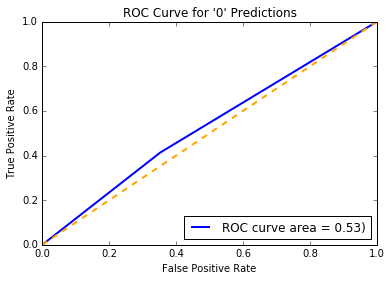

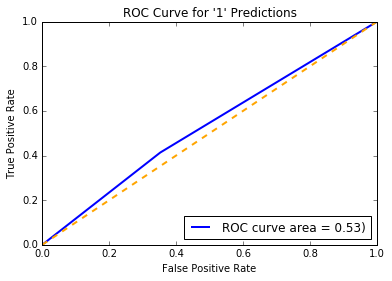

In [157]:
model_evaluation(best_model.predict(original_X), original_y)

Our model score of .44 seems quite low, and our ROC curve is barely above the baseline in the orange dash. However, lets refocus towards our primary business purpose. Our main goal is to accurately predict negative reviews. When assessing true negative rate below, we see a substantial rise from our baseline and thus we can accurately capture any negative sentiment the users may express. In the end, we believe we have accomplished our business goal which is to get better prediction on negative reviews.

In [150]:
counter = 0
total_neg = 0
for i in range(len(b)):
    if b[i] == original_y[i] and b[i] == 0:
        counter += 1
    if original_y[i] == 0:
        total_neg += 1
print float(counter)/float(total_neg)

0.64738292011


<a id='insight'></a>
# What can we learn from our features?

An interesting business application to this sentiment analysis is the ability to identify words that are particularly indicative of negative or positive reviews. In some cases, this could be a feature or camera aspect that may be particularly troublesome. Below we will use our modeling results and targeted feature selection to try and uncover areas of interest for a few brands.  

One indication of the weight of certain words to the sentiment can be the coefficients from a logistic regression model. Below we adapt code from class to expose these top contributing words. Interestingly, when glancing through the top features, we can infer some potential areas of improvement for Nikon in their products. "Write", likely referring to the write time to disk after taking a photograph is one that jumps out. "Lithium batteries" and "redeye" might also give good indication of potential shortcomings.

In [108]:
df_nikon = df_cameras.loc[df_cameras['brand']=='Nikon', ]
tfidf_nikon = TfidfVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)
X_tfidf_nikon = tfidf_nikon.fit_transform(df_nikon['text'].values)
X_nikon = X_tfidf_nikon.toarray()
y_nikon = [1 if i == ' Yes' else 0 for i in df_nikon['label'].tolist()]
y_nikon = np.array(y_nikon)
clf_logit_nikon = LogisticRegression(penalty='l1', C= 9.9)
clf_logit_nikon.fit(X_nikon, y_nikon)
# code adapted from Zico Kolter Data Science Walkthrough notebook
feature_names_nikon = np.array(tfidf_nikon.get_feature_names())
sorted(zip(feature_names_nikon, clf_logit_nikon.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True)[:40]

[(u'result', -23.354927059995966),
 (u'write', -22.657879339866522),
 (u'turned', -20.831391357424675),
 (u'horrible', -20.028732786475075),
 (u'outdoor', -16.20274808062149),
 (u'returned', -16.201412119939707),
 (u'camera months', -15.72142477078256),
 (u'time time', -15.36343134548574),
 (u'case', 14.525174086982947),
 (u'fix', -13.772266647351481),
 (u'cameras ve', -13.428635392600663),
 (u'yes', -13.200619021300279),
 (u'lithium batteries', -12.494095617826034),
 (u'advertised', -11.77256715018688),
 (u'repair', -11.575554798697969),
 (u'port', 10.600750100564165),
 (u'redeye', -10.510171286044562),
 (u'clear', 10.326741723808297),
 (u'cd1000', -10.293689705327433),
 (u'nikon coolpix 775', -10.007744337875275),
 (u'disappointing', -9.9993693761321687),
 (u'cams', -9.9722005231028152),
 (u'research', 9.9455592228959233),
 (u'noticeably', -9.8291315741209928),
 (u'cards', 9.1748582304449187),
 (u'customer', -9.1579537311428485),
 (u'useless', -9.117760725994156),
 (u'nightshot', -8.

When looking at the active words for Olympus, we can sift through some heavy opinion sharing words to see a few potential areas of improvement. "Slow" is particularly high on the list and might be a good indication that Olympus should explore the speed at which their phone performs normal functions. Further down the list we can see two separate words that may together indicate opportunity for Olympus, "eats" and "duracell". Perhaps rapid battery depletion is a concern for Olympus users.

In [109]:
df_ol = df_cameras.loc[df_cameras['brand']=='Olympus', ]
tfidf_ol = TfidfVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words = 'english', lowercase = True)
X_tfidf_ol = tfidf_ol.fit_transform(df_ol['text'].values)
X_ol = X_tfidf_ol.toarray()
y_ol = [1 if i == ' Yes' else 0 for i in df_ol['label'].tolist()]
y_ol = np.array(y_ol)
clf_logit_ol = LogisticRegression(penalty = 'l1', C=9.9)
clf_logit_ol.fit(X_ol, y_ol)
# code adapted from Zico Kolter Data Science Walkthrough notebook
feature_names_ol = np.array(tfidf_ol.get_feature_names())
sorted(zip(feature_names_ol, clf_logit_ol.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True)[:40]

[(u'poor', -16.634231575636317),
 (u'cheap', -15.755831267976768),
 (u'worse', -15.549074942198683),
 (u'certain', -15.18369962632671),
 (u'post', -14.850326443578647),
 (u'slow', -12.271994873447893),
 (u'sun', -11.897348513166351),
 (u'equivalent', -11.866612547877505),
 (u'lack', -11.729314782422598),
 (u'called', -11.116866467391105),
 (u'similar', -11.004810674696174),
 (u'download images', -10.994270617018071),
 (u'eats', -10.201474311176314),
 (u'duracell', -9.1468235550160912),
 (u'away', -8.9792313344023906),
 (u'rechargeable', 8.6524384812794395),
 (u'work', -8.4945242597621498),
 (u'bad', -8.2619738493081289),
 (u'seconds', -8.0660196484624329),
 (u'polaroid', -7.7775873551083068),
 (u'146t', 7.7301483643671505),
 (u'35', 7.0518026372961291),
 (u'door', -6.743468690619749),
 (u'takes seconds', -6.6814959020663327),
 (u'pictures taken', -6.662474498560524),
 (u'rechargable', -6.5789354274103227),
 (u'companies', -6.5582480963402379),
 (u'fact', -6.526002881271034),
 (u'usable

In order to get a better visualization of the top features, we constructed wordcloud below for the top negative words from 
Nikon and the top positive words from Olympus.

In [110]:
list_feat_nikon=sorted(zip(feature_names_nikon, clf_logit_nikon.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True)[:100]
str_neg_nikon= ''
str_pos_nikon = ''
for i in list_feat_nikon:
    if i[1] >0:
        for j in range(int(i[1])):
            str_pos_nikon += i[0] + ' '
    else:
        for j in range(np.abs(int(i[1]))):
            str_neg_nikon += i[0] + ' '
f = open('pos_nikon.txt','w')
f.write(str_pos_nikon) 
f.close()
f = open('neg_nikon.txt','w')
f.write(str_neg_nikon) 
f.close()

list_feat_ol=sorted(zip(feature_names_ol, clf_logit_ol.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True)[:100]
str_neg_ol= ''
str_pos_ol = ''
for i in list_feat_ol:
    if i[1] >0:
        for j in range(int(i[1])):
            str_pos_ol += i[0] + ' '
    else:
        for j in range(np.abs(int(i[1]))):
            str_neg_ol += i[0] + ' '
f = open('pos_ol.txt','w')
f.write(str_pos_ol) 
f.close()
f = open('neg_ol.txt','w')
f.write(str_neg_ol) 
f.close()

The wordclouds below can give us a visual representation of the positive and negative aspect of these two brands. On the left we have a representation of the negative aspects of Nikon and on the right we have the positive aspects of the Olympus. Top areas of opportunity jump out for Nikon as redeye, batteries, outdoor, support, and write[time]. On the other hand, the positive aspects for Olympus jump out as rechargeable, intuitive, and compact. A mere glance at these two wordclouds give good insight into the strengths and weaknesses of these two brands. 

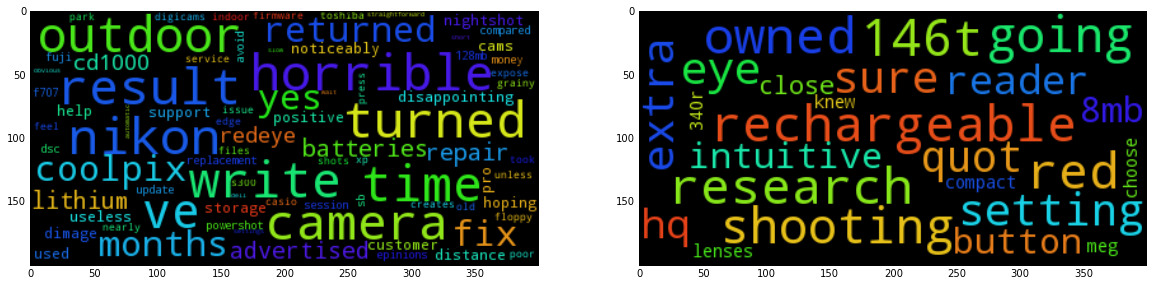

In [115]:
#wordcloud 
#wordcloud package is downloaded from https://github.com/amueller/word_cloud
fig, ax = plt.subplots(nrows = 1, ncols= 2,  figsize=(20,20))
list_ax = []

filenames = ['neg_nikon.txt', 'pos_ol.txt']
for i in range(2):          
    # Read the whole text.
    text = open(filenames[i]).read()
    # Generate a word cloud image
    wordcloud = WordCloud(max_font_size=40).generate(text)    
    list_ax.append(ax[i].imshow(wordcloud, cmap=plt.get_cmap('gray')))

#plt.figure()
#plt.imshow(wordcloud)
#plt.axis("off")
plt.show()

## Conclusion

Quantifying sentiment is a multi-faceted challenge. Performing data science on text data presents new and unique obstacles which require creative thinking and research to identify solutions. For this project, we had the opportunity to learn two feature selection approaches: selection based on ranking (chi-square and info gain), and selection based on how well they work with classifiers (orthogonal matching pursuit). We also brought in knowledge we gained throughout the semester such as utilizing different classification algorithms and performing grid search to find best model parameters to this project. We concluded this project with our business goal in mind, which is to build a superior model to predict negative reviews, and we were able to achieve this goal and take a closer look at the top features for specific camera brands in the last section. 

We had a fantastic experience working on this text classification challenge and we both look forward to taking what we learned how to do (and what not to do!) forward in future projects! Many thanks to Professor Kolter, Eric and Dhivya for an amazing semester!